# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [473]:
# # Google Colab을 사용하는 경우 해당 셀을 실행하세요
# %%capture
# import sys

# if 'google.colab' in sys.modules:
#     # Install packages in Colab
#     !pip install category_encoders==2.*
#     !pip install eli5
#     !pip install pandas-profiling==2.*
#     !pip install pdpbox
#     !pip install shap

In [474]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import uniform

In [475]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [476]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
# > EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [477]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [478]:
pd.DataFrame([train.dtypes, test.dtypes], index=['train', 'test'])

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,int64,object,object,float64,object,object,object,object,object,float64,object,object,object,float64,float64,object,int64
test,int64,object,object,float64,object,object,object,object,object,float64,object,object,object,float64,float64,object,int64


In [479]:
pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,0,717,4,1427,24,0,45,15,13,0,0,15870,178,178,178,0
test,0,0,235,0,452,2,0,11,3,4,0,0,5336,60,60,60,0


In [413]:
train['Violations'].unique()

array([nan,
       '34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: OBSERVED BOXES OF POTATO CHIPS STORED ON THE FLOOR OF DRY STORAGE. INSTRUCTED TO STORE ALL FOOD 6 INCHES ABOVE THE FLOOR TO PROPERLY CLEAN THE FLOOR. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: OBSERVED THE WASTE PIPE LEAKING AT THE 3 COMPARTMENT SINK MIDDLE BASIN. INSTRUCTED TO REPAIR AND MAINTAIN ALL PLUMBING.  | 42. APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN - Comments: OBSERVED A FOOD HANDLER WITH NO HAIR RESTRAINT. INSTRUCTED TO WEAR A HAIR RESTRAINT WHEN HANDLING FOOD.',
       '30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED - Comments: MUST DATE AND LABEL ALL LARGE PLASTIC TUB CONTAINERS HOLDING CHICKEN IN THE BOTH 2-SLIDING DOOR COOLERS IN THE REAR PART OF THE STORE WHERE THERE ARE 3 SMALL CUSTOMER TABLE

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [480]:
# Inspection ID 컬럼은 조사의 고유 번호이므로 실제 분석에 무의미하다고 판단하여 제거
train.drop('Inspection ID', axis=1, inplace=True)
test.drop('Inspection ID', axis=1, inplace=True)

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,717,4,1427,24,0,45,15,13,0,0,15870,178,178,178,0
test,0,235,0,452,2,0,11,3,4,0,0,5336,60,60,60,0


In [481]:
# AKA Name, License #, Address 컬럼은 DBA Name 컬럼과 역할이 동일하다고 판단되어 제거
train.drop(['AKA Name', 'License #', 'Address'], axis=1, inplace=True)
test.drop(['AKA Name', 'License #', 'Address'], axis=1, inplace=True)

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,1427,24,45,15,13,0,0,15870,178,178,178,0
test,0,452,2,11,3,4,0,0,5336,60,60,60,0


In [482]:
# License #, Facility Type, Risk, City, State, Zip, Latitude, Longitude, Location 컬럼은 결측치 수가 데이터 수의 10% 미만이므로 결측치 있는 행 제거

# 결측치 수가 가장 많은 Facility Type 컬럼의 결측치 먼저 제거
train = train[~train['Facility Type'].isna()]
test = test[~test['Facility Type'].isna()]

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,0,4,42,15,12,0,0,14487,172,172,172,0
test,0,0,1,11,3,4,0,0,4889,58,58,58,0


In [483]:
# Location 컬럼의 결측치 제거
train = train[~train['Location'].isna()]
test = test[~test['Location'].isna()]

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,0,4,41,15,11,0,0,14437,0,0,0,0
test,0,0,1,10,3,3,0,0,4876,0,0,0,0


In [484]:
# Risk, City, State, Zip 컬럼의 결측치 제거
train = train[~train['Risk'].isna()]
test = test[~test['Risk'].isna()]

train = train[~train['City'].isna()]
test = test[~test['City'].isna()]

train = train[~train['State'].isna()]
test = test[~test['State'].isna()]

train = train[~train['Zip'].isna()]
test = test[~test['Zip'].isna()]

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
train,0,0,0,0,0,0,0,0,14405,0,0,0,0
test,0,0,0,0,0,0,0,0,4869,0,0,0,0


In [485]:
# Violations 컬럼은 결측치 수가 데이터 수의 10%를 초과하므로 컬럼 자체를 제거해야할 것 같지만,
# 컬럼 값의 맨 앞에 위반 사항 번호가 있으므로 이 숫자만 따로 분리. 결측치는 최빈값으로 대체
def splitViolationsNum(input):
  if input is np.NaN:
    return np.NaN
  else:
    return str(input).split('.', 1)[0]

In [486]:
train['Violations'] = train['Violations'].fillna(train['Violations'].mode()[0]).apply(splitViolationsNum).astype(int)
test['Violations'] = test['Violations'].fillna(test['Violations'].mode()[0]).apply(splitViolationsNum).astype(int)

In [487]:
train.head()

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,MY SWEET STATION INC,Restaurant,Risk 1 (High),CHICAGO,IL,60614.0,2017-05-18,Canvass,30,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,OUTTAKES,Restaurant,Risk 2 (Medium),CHICAGO,IL,60603.0,2017-08-14,Canvass,34,41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,JAFFA BAGELS,Restaurant,Risk 1 (High),CHICAGO,IL,60601.0,2015-12-15,Complaint,30,41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,FRANKS 'N' DAWGS,Restaurant,Risk 1 (High),CHICAGO,IL,60614.0,2012-07-10,Canvass,33,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,SOUTH COAST,Restaurant,Risk 1 (High),CHICAGO,IL,60616.0,2013-09-20,Canvass,30,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [488]:
# Location은 Latitude와 Longitude를 합친 것뿐이므로 제거
train.drop('Location', axis=1, inplace=True)
test.drop('Location', axis=1, inplace=True)

pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test'])

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Inspection Fail
train,0,0,0,0,0,0,0,0,0,0,0,0
test,0,0,0,0,0,0,0,0,0,0,0,0


In [489]:
# Zip 컬럼은 우편 번호같은 역할이므로 수치형이 아닌 범주형으로 판단하여 형변환
train['Zip'] = train['Zip'].astype(str)
test['Zip'] = test['Zip'].astype(str)

In [490]:
# Inspection Date를 이용하여 조사한 날짜의 요일 및 연/월/일 컬럼 추가하기
train['Inspection Date'] = pd.to_datetime(train['Inspection Date'])
test['Inspection Date'] = pd.to_datetime(test['Inspection Date'])

train['Inspection DayOfWeek'] = train['Inspection Date'].dt.dayofweek
test['Inspection DayOfWeek'] = test['Inspection Date'].dt.dayofweek

train['Inspection Year'] = train['Inspection Date'].dt.year
test['Inspection Year'] = test['Inspection Date'].dt.year

train['Inspection Month'] = train['Inspection Date'].dt.month
test['Inspection Month'] = test['Inspection Date'].dt.month

train['Inspection Day'] = train['Inspection Date'].dt.day
test['Inspection Day'] = test['Inspection Date'].dt.day

# Inspection Date는 불필요하므로 제거
train.drop('Inspection Date', axis=1, inplace=True)
test.drop('Inspection Date', axis=1, inplace=True)

In [427]:
train.head()

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Inspection Fail,Inspection DayOfWeek,Inspection Year,Inspection Month,Inspection Day
0,MY SWEET STATION INC,Restaurant,Risk 1 (High),CHICAGO,IL,60614.0,Canvass,30,41.927577,-87.651528,0,3,2017,5,18
1,OUTTAKES,Restaurant,Risk 2 (Medium),CHICAGO,IL,60603.0,Canvass,34,41.881807,-87.629543,0,0,2017,8,14
2,JAFFA BAGELS,Restaurant,Risk 1 (High),CHICAGO,IL,60601.0,Complaint,30,41.886377,-87.624382,0,1,2015,12,15
3,FRANKS 'N' DAWGS,Restaurant,Risk 1 (High),CHICAGO,IL,60614.0,Canvass,33,41.914990,-87.654994,0,1,2012,7,10
4,SOUTH COAST,Restaurant,Risk 1 (High),CHICAGO,IL,60616.0,Canvass,30,41.858996,-87.624106,0,4,2013,9,20


In [428]:
train.dtypes

DBA Name                 object
Facility Type            object
Risk                     object
City                     object
State                    object
Zip                      object
Inspection Type          object
Violations                int64
Latitude                float64
Longitude               float64
Inspection Fail           int64
Inspection DayOfWeek      int64
Inspection Year           int64
Inspection Month          int64
Inspection Day            int64
dtype: object

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

0    0.801352
1    0.198648
Name: Inspection Fail, dtype: float64

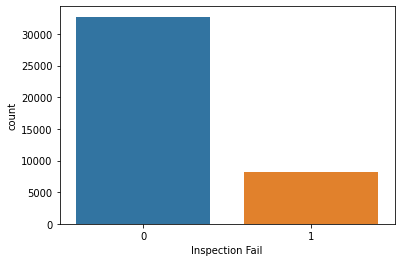

In [437]:
# 타겟(Inspection Fail)의 클래스 비율 확인해보기 - 기준 성능(분류)
sns.countplot(x=train['Inspection Fail']);
train['Inspection Fail'].value_counts(normalize=True)
# Inspection Fail는 클래스 비율이 불균형하므로 학습 시 class_weight 관련 설정이 필요

In [429]:
# 검증 방식 : Cross Validation

# 훈련 / 검증 / 테스트 셋으로 분리
train, val = train_test_split(train, test_size=0.30, random_state=2)

train.shape, val.shape, test.shape

((40841, 15), (17504, 15), (19476, 15))

In [430]:
# 특성과 타겟 분리하기
target = 'Inspection Fail'
features = train.drop(columns=target).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.head()

,DBA Name,Facility Type,Risk,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Inspection DayOfWeek,Inspection Year,Inspection Month,Inspection Day
42525,HAHN LIQUORS,Liquor,Risk 3 (Low),CHICAGO,IL,60660.0,License,5,41.998239,-87.665999,2,2020,5,27
33079,ALICE'S RESTAURANT,Restaurant,Risk 1 (High),CHICAGO,IL,60651.0,Canvass,32,41.894942,-87.766879,0,2011,4,25
43385,THE ARK,Restaurant,Risk 1 (High),CHICAGO,IL,60645.0,Canvass,32,41.999067,-87.699836,3,2011,4,14
46125,FRESH MARKET PLACE,Grocery Store,Risk 1 (High),CHICAGO,IL,60647.0,Canvass Re-Inspection,18,41.920932,-87.687666,3,2016,9,1
807,LA FIESTA BAKERY,Restaurant,Risk 1 (High),CHICAGO,IL,60629.0,Complaint,33,41.776073,-87.722841,3,2012,6,28


## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [431]:
# 분류 문제이므로 랜덤 포레스트 또는 그래디언트 부스팅 모델을 사용
# 여기서는 부스팅 모델 사용

# 범주 간의 순서가 없는 특성 - TargetEncoder
tge_col = ['DBA Name', 'Facility Type', 'City', 'State', 'Zip', 'Inspection Type']
# 범주 간의 순서가 있는 특성(소/중/대) - OrdinalEncoder
ord_col = ['Risk']

In [445]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    {0:80, 1:20},
    y = train['Inspection Fail']
)

In [441]:
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

In [446]:
pipe = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBClassifier(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , eval_set=eval_set
              , eval_metric='auc'
              , subsample=0.9
              , colsample_bytree=0.5
              , sample_weight=classes_weights
              , early_stopping_rounds=50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤
)

pipe.fit(X_train, y_train);

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [447]:
y_pred_train = pipe.predict(X_train)
roc_auc = roc_auc_score(y_train, y_pred_train)
print(f'Train ROC_AUC_SCORE: {roc_auc}')

y_pred_val = pipe.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred_val)
print(f'Val ROC_AUC_SCORE: {roc_auc}')

y_pred = pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Test ROC_AUC_SCORE: {roc_auc}')

Train ROC_AUC_SCORE: 0.9105750167903058
Val ROC_AUC_SCORE: 0.7434765469150774
Test ROC_AUC_SCORE: 0.7082500297323866


## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [448]:
dists = {
    'xgbclassifier__max_depth': [1, 2, 3, 4, 5],
    'xgbclassifier__learning_rate': uniform(0.01, 0.2),
    'xgbclassifier__max_features': uniform(0, 1)
}

# 과적합 줄이기 및 최적화
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 17.3min finished


In [451]:
pipe_opt = clf.best_estimator_

In [452]:
y_pred_train_opt = pipe_opt.predict(X_train)
roc_auc = roc_auc_score(y_train, y_pred_train_opt)
print(f'Train ROC_AUC_SCORE: {roc_auc}')

y_pred_val_opt = pipe_opt.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred_val_opt)
print(f'Val ROC_AUC_SCORE: {roc_auc}')

y_pred_opt = pipe_opt.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_opt)
print(f'Test ROC_AUC_SCORE: {roc_auc}')

Train ROC_AUC_SCORE: 0.9834245820531268
Val ROC_AUC_SCORE: 0.7432755269833627
Test ROC_AUC_SCORE: 0.7093108620545094


## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [455]:
# Permutation Importances

# permuter 정의
permuter = PermutationImportance(
    pipe_opt.named_steps['xgbclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용
encoder = make_pipeline(TargetEncoder(cols=tge_col), OrdinalEncoder(cols=ord_col))
X_val_encoded = encoder.fit_transform(X_val, y_val)
# X_val_transformed = pipe_opt.named_steps['ordinalencoder'].transform(X_val)

permuter.fit(X_val_encoded, y_val);

In [458]:
# 특성별 score 확인
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

# 식당의 위생 검사 결과에 가장 영향을 주는 특성으로 Violations(위반 사항)가 나왔다.
# 그 뒤로는 식당의 상호명(법적 명칭)과 조사 방식이 영향을 많이 주었다.

Weight,Feature
0.1366 ± 0.0028,Violations
0.0679 ± 0.0020,DBA Name
0.0112 ± 0.0007,Inspection Type
0.0087 ± 0.0014,Inspection Year
0.0020 ± 0.0009,Longitude
0.0016 ± 0.0012,Inspection Day
0.0013 ± 0.0011,Risk
0.0012 ± 0.0011,Inspection DayOfWeek
0.0011 ± 0.0012,Facility Type
0.0011 ± 0.0019,Inspection Month


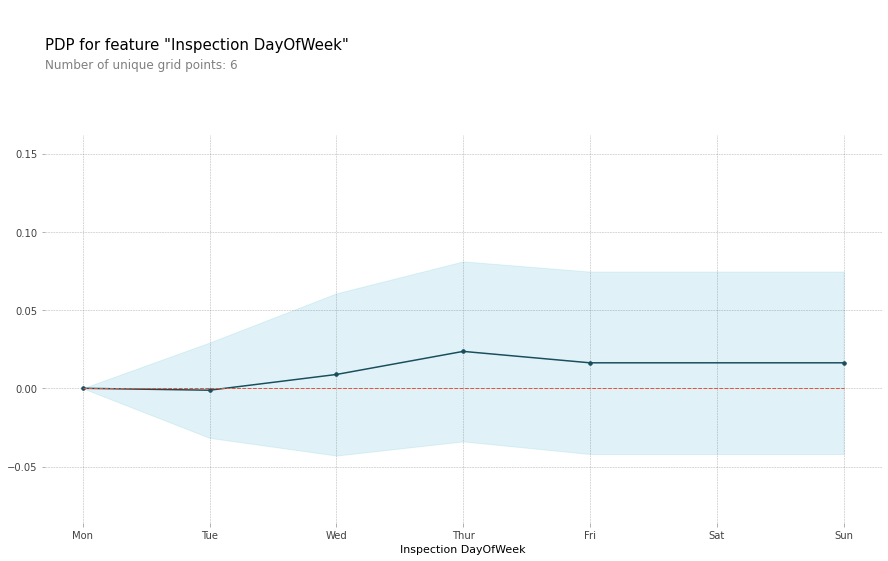

In [466]:
# 1D PDP
feature = 'Inspection DayOfWeek'

isolated = pdp_isolate(
    model=pipe_opt, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);
plt.xticks(np.arange(0, 7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

# 다른 요일에 비해 월, 화요일에는 조사 결과에 영향을 주지 못하는 것으로 보인다.
# 조사원들의 월요병(?)으로 인한 업무 효율 저하일까,
# 혹은 새로운 일주일을 맞아 식당이 깨끗하게 청소를 한 것일까? 여기서는 알 수 없다.

In [467]:
# 2D PDP
features = ['Longitude', 'Latitude']

interaction = pdp_interact(
    model=pipe_opt, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


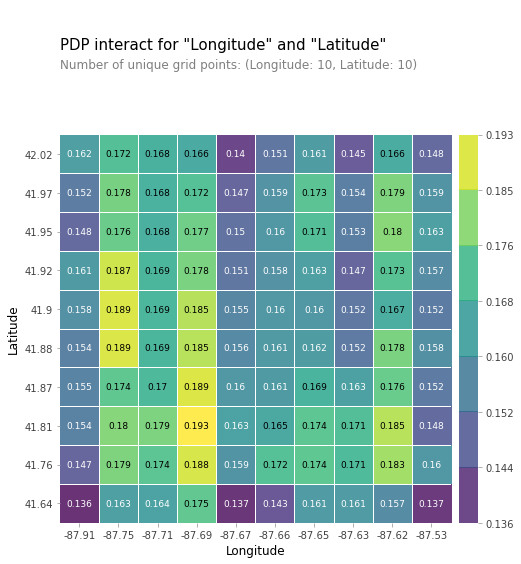

In [468]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# 경도 -87.75에 위도 41.88~41.92 지역과 경도 -87.69에 위도 41.76~41.87 지역의 식당에서 위생 상태 불량한 결과가 다수 존재하는 것으로 보인다.
# 실제 지도 확인해보니 번화가 지역이라서 식당이 많은 곳이다.

In [470]:
import shap

In [471]:
# SHAP
model = pipe_opt.named_steps['xgbclassifier']
# encoder = make_pipeline(TargetEncoder(cols=tge_col), OrdinalEncoder(cols=ord_col))
# X_val_encoded = encoder.fit_transform(X_val, y_val)

shap.initjs()
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val_encoded.iloc[:300])
shap.force_plot(explainer.expected_value, shap_values, X_val_encoded.iloc[:300])

# Violations(위반 사항) 번호 30을 기준으로 아래로는 위생 검사 불합격, 위로는 합격에 영향을 주었다.
# Inspeciton Year(조사 년도)는 2012년을 기준으로 이전에는 불합격, 이후로는 합격에 영향을 주었다.
# Risk(위험도)가 1(Highest)인 경우 위생 검사 불합격에 영향이 크다.

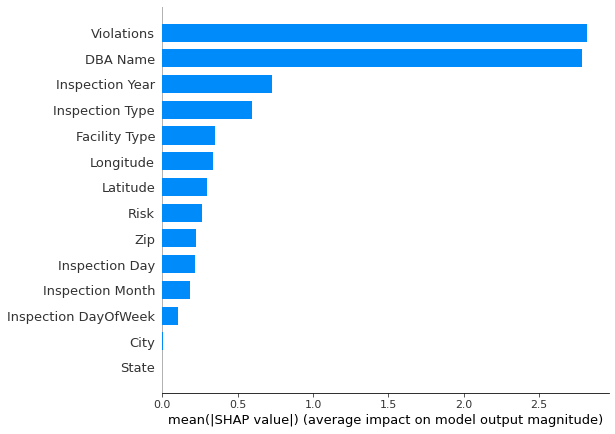

In [472]:
shap.summary_plot(shap_values, X_val_encoded.iloc[:300], plot_type="bar")
# Permutation Importances와 동일하게 Violations와 DBA Name이 가장 큰 영향력을 주는 것으로 보인다.
# Inspection Year가 Inspection Type보다 영향력이 큰 것은 Permutation Importances와 차이가 있다.
# Permutation Importances에서는 하위권이었던 Facility Type이 SHAP Value로는 상위에 속해있다.
# City와 State는 여기서도 영향력이 0인데, 이는 모든 데이터가 동일한 값을 갖고 있기 때문이다.